In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_flat = x_train.reshape(60000, 784).astype("float32") / 255
x_test_flat = x_test.reshape(10000, 784).astype("float32") / 255
x_train = x_train / 255
x_test = x_test / 255
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
x_train.shape

(60000, 28, 28)

In [3]:
# BUILD MODEL
from tensorflow.keras import backend as K

def sample_z(mu,sigma):
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

class Add_kl_loss(layers.Layer):
    
    def call(self,inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        #self.add_loss(kl_loss + 27)
        #self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        return kl_loss

def create_encoder(inp_layer,latent_dim,inp_label):
    # inp_y = keras.Input(shape=label_shape,name='label')
    #encoder_input = keras.layers.concatenate()
    # Definition
    #label = layers.Input(shape=(label_dim,), name='label_input')
    
    #inputs = layers.Concatenate([inp_layer, inp_label])


    cx      = layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(inp_layer)
    cx      = layers.BatchNormalization()(cx)
    cx      = layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
    cx      = layers.BatchNormalization()(cx)
    x       = layers.Flatten()(cx)
    #print('tjo')
    xi      = layers.Concatenate(axis=1)([x, inp_label])
    #print('tjo')


    x       = layers.Dense(20, activation='relu')(xi)
    x       = layers.BatchNormalization()(x)
    z_mean      = layers.Dense(latent_dim, name='latent_mu')(x)
    z_log_var   = layers.Dense(latent_dim, name='latent_sigma')(x)
    # Used in Decoder:
    z = sample_z(z_mean,z_log_var)
    kl_loss = Add_kl_loss()([z_mean,z_log_var])
    # Get Conv2D shape for Conv2DTranspose operation in decoder
    conv_shape = K.int_shape(cx)
    
    # Instantiate encoder
    encoder = keras.Model(inputs=[inp_layer,inp_label], outputs=[z_mean,z_log_var, z], name='encoder')
    encoder.add_loss(kl_loss)
    encoder.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    #encoder.summary()
    
    return encoder, conv_shape
    

def create_decoder(latent_dim,conv_shape,inp_label):    
    # =================
    # Decoder
    # =================

    # Definition
    d_i   = layers.Input(shape=(latent_dim, ), name='decoder_input')
    #inp_label = layers.Input(shape=(label_dim,), name='label_input')
    #d_i = layers.Embedding(2)(d_i)
    #inp_label = layers.Embedding(10)(inp_label)
    
    inputs = layers.Concatenate(axis=1)([d_i, inp_label])

    x     = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(inputs)
    x     = layers.BatchNormalization()(x)
    x     = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    cx    = layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    cx    = layers.BatchNormalization()(cx)
    cx    = layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
    cx    = layers.BatchNormalization()(cx)
    o     = layers.Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
    
    decoder = keras.Model(inputs=[d_i,inp_label],outputs=o, name='decoder')
    return decoder
    
def get_vae(inp_layer,inp_label,latent_dim):
    
    encoder, conv_shape = create_encoder(inp_layer, latent_dim,inp_label)
    decoder = create_decoder(latent_dim, conv_shape,inp_label)
    
    reconstruction = decoder([encoder([inp_layer,inp_label])[2],inp_label])
    vae = keras.Model(inputs=[inp_layer,inp_label], outputs=reconstruction, name='vae')
    vae.add_loss(encoder.losses)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    #reconstruction_loss = tf.keras.losses.MeanSquaredError(reconstruction, inp_layer)
    #vae.add_loss(reconstruction_loss)
    
    vae.compile(optimizer,loss=reconstruction_loss)
    vae.summary()
    return encoder,decoder,vae

def reconstruction_loss(data,target):
    reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, target)
            )
    reconstruction_loss *= 28 * 28
    return reconstruction_loss


In [4]:
inp_shape = (28,28,1)
label_dim = 10
inp_x = keras.Input(shape=inp_shape, name="img")
inp_label = keras.Input(shape=label_dim, name='label_input')
encoder,decoder,vae = get_vae(inp_x,inp_label,2)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 17408       img[0][0]                        
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    16977       encoder[0][2]                  

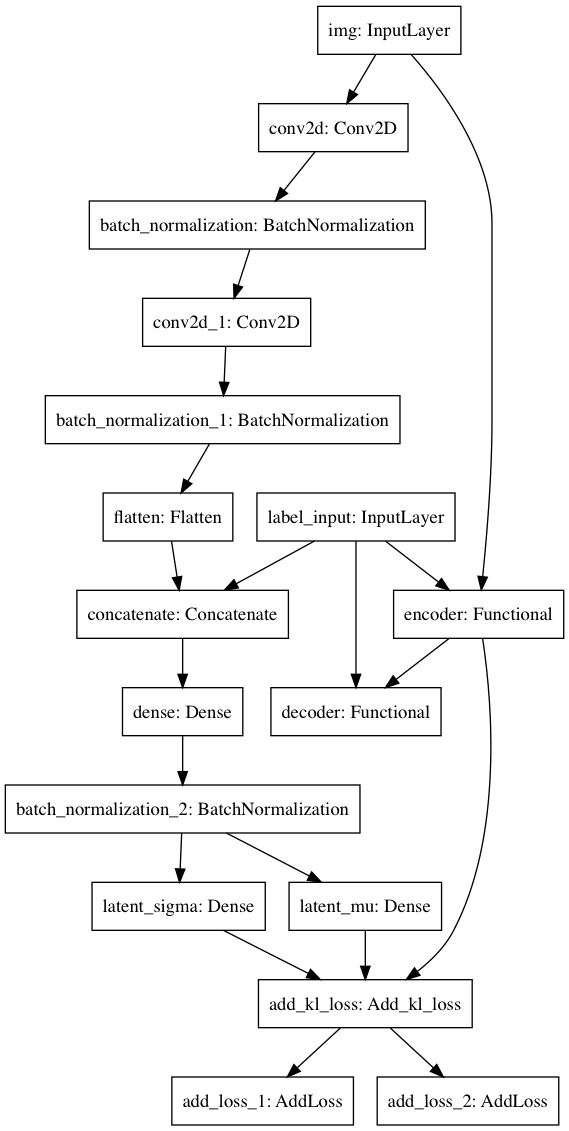

In [5]:
keras.utils.plot_model(vae)

In [11]:
# TRAIN
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#reconstruction_loss = tf.keras.losses.MeanSquaredError(reconstruction, inp_layer)
#vae.add_loss(reconstruction_loss)
vae.compile(optimizer,loss= tf.keras.losses.MeanSquaredError())
#vae.add_metric(reconstruction_loss, name='rec_loss', aggregation='mean')


history = vae.fit([x_train,y_train], x_train, epochs=1, batch_size=128,verbose=1)

469/469 [==============================] - 35s 75ms/step - loss: 81.2389 - kl_loss: 27.0500


dict_keys(['loss', 'kl_loss'])


[]

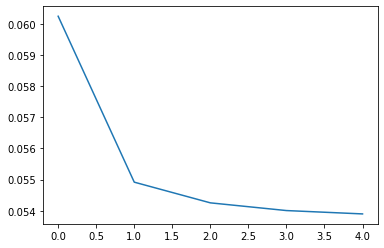

In [22]:
print(history.history.keys())
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot()

## SAVE MODELS

In [10]:
keras.utils.plot_model(vae, "multi_input_and_output_model.png", show_shapes=True)

vae.save_weights('test')

## LOAD SAVED MODEL

In [7]:
inp_shape = (28,28,1)
label_dim = 10

inp_x = keras.Input(shape=inp_shape, name="img")
inp_label = layers.Input(shape=label_dim, name='label_input')
encoder,decoder,loaded_model = get_vae(inp_x,inp_label,2)
loaded_model.load_weights('test')

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 17408       img[0][0]                        
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    16977       encoder[0][2]                  

In [8]:
# Another notation which also works to use.. more intuitive??
loaded_model.fit({'img': x_train,'label_input':y_train}, x_train, epochs=3, batch_size=64)
loaded_model.save_weights('test')

Epoch 1/3
938/938 [==============================] - 35s 37ms/step - loss: 35.3573 - kl_loss: 1.4053
Epoch 2/3
938/938 [==============================] - 34s 36ms/step - loss: 34.3451 - kl_loss: 1.3168
Epoch 3/3
938/938 [==============================] - 35s 37ms/step - loss: 34.1159 - kl_loss: 1.3119


hej


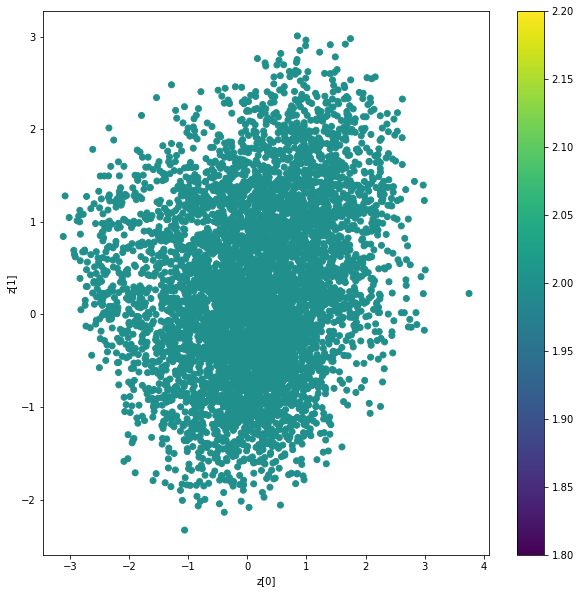

In [9]:
from plot_functions import *
#import importlib
#importlib.reload(plot_functions) 
yy = np.argmax(y_train,axis=-1)
ind = np.where(yy==2)
#print(ind)
xx = x_train[ind,:,:]
y = y_train[ind,:]

plot_label_clusters(encoder, decoder, xx[0,:,:,:], y[0,:,:], yy[ind], saveas='okok',verbose=2)
#plot_label_clusters(encoder, decoder, x_train, y_train, yy, saveas='okok',verbose=2)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


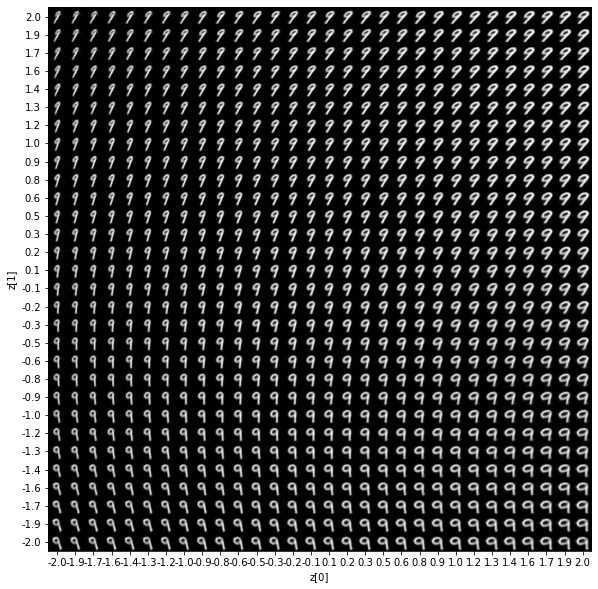

In [25]:
from plot_functions import *
condition_on = 9

cond = np.zeros((1,10))
cond[0][condition_on] = 1
print(cond)

plot_latent(encoder, decoder, saveas=None,verbose=0, conditional=cond)

In [14]:
def cluster(vae,x,cond,eta,gamma,m):
    for i in range(m):
        if i%100==0:
            print(f'Running clustering procedure, iteration={i}')
        x_hat = x + eta*tf.random.normal(shape=x.shape)
        x_rec = vae.predict([x_hat,cond])
        x = x - gamma*(x_hat-x_rec)
    return x

condition_on = 9

x_cluster = x_test[0:200,:,:]
x_cluster = np.reshape(x_cluster, (200,28,28,1))
cond = np.zeros((200,10))
cond[:,condition_on] = 1
x_new = cluster(loaded_model,x_cluster,cond,0.1,0.02,100)
print('Done...')

Running clustering procedure, iteration=0
Done...


hej


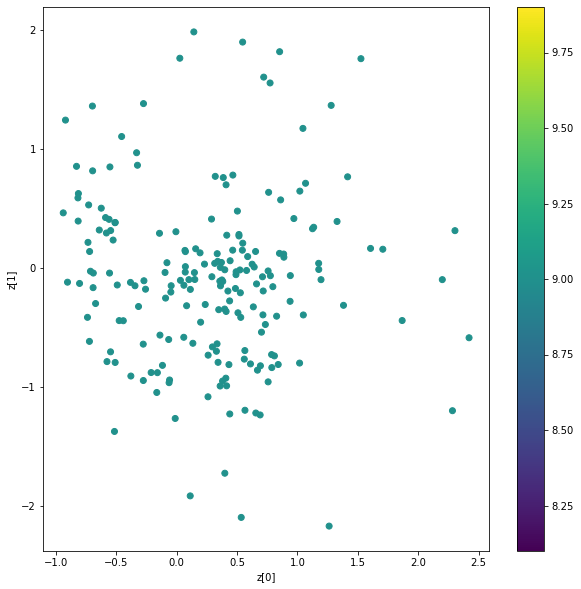

In [15]:
yy = np.argmax(cond,axis=-1)
plot_label_clusters(encoder, decoder, x_new, cond, yy, saveas='okok',verbose=2)

Running clustering procedure, iteration=0
Running clustering procedure, iteration=100
Running clustering procedure, iteration=200
Running clustering procedure, iteration=300
Running clustering procedure, iteration=400
hej


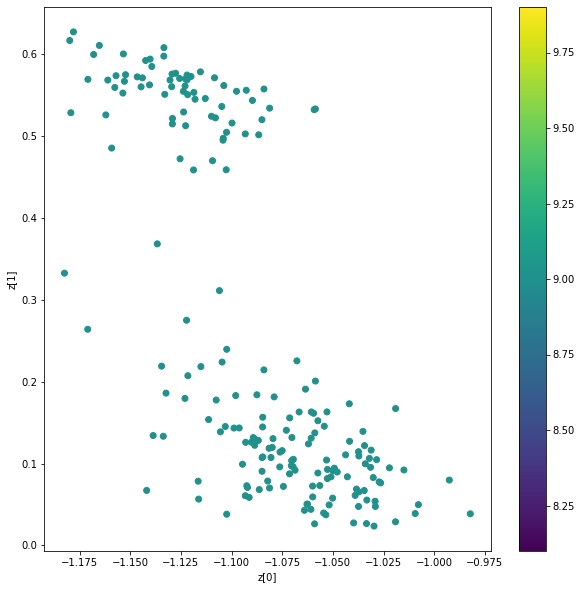

In [22]:
yy = np.argmax(cond,axis=-1)
x_new = cluster(new_model,x_new,cond,0.1,0.02,500)
#z = np.random.multivariate_normal()
plot_label_clusters(encoder, decoder, x_new, cond, yy, saveas='okok',verbose=2)

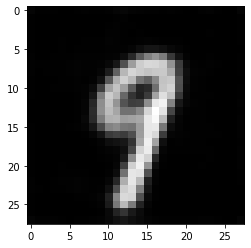

In [24]:
z = np.array([[-1,0.55]])
condition_on = np.array([[0,0,0,0,0,0,0,0,0,1]])
x_decoded = decoder([z,condition_on])
x_decoded = x_decoded.numpy()
digit = x_decoded[0].reshape(28, 28)
plt.imshow(digit, cmap=plt.get_cmap('gray'))

## Clustering

In [11]:
from os import environ, path

np_path = "clusters/second_run.csv.npy"
n_sample = 100

x_cluster = x_test[0:200,:,:]
x_cluster = np.reshape(x_cluster, (200,28,28,1))
cond = np.zeros((200,10))
cond[:,condition_on] = 1

if path.isfile(np_path):
    x_new = np.load(np_path)
    print(f'Saved clusters: {np_path} loaded Succesfully...')
    x = x_new
else:
    x = input_test[0:n_sample,:,:,:]
    print('OBSOBSOBSOB')
    print('starting fresh....')

plot_label_clusters(encoder, decoder, x, cond, yy, saveas=im_path+'_original.png', verbose=2)

if cont_training==True:
    m = 1000
    gamma = .01
    eta = 0.01
    #x = input_test[0:n_sample,:,:,:]
    print(f'Continues clustering on file: {np_path} for {m} iterations...')
    x_new = cluster(new_model,x_new,cond,eta,gamma,m)

    
plot_label_clusters(encoder, decoder, x_new, cond, yy, saveas=im_path+'_original.png', verbose=2)


plot_label_clusters(my_vae.encoder, my_vae.decoder, x_new, target_test[0:n_sample], saveas=im_path+'_clustered.png')

np.save(np_path, x_new)

NameError: name 'input_test' is not defined

NameError: name 'np' is not defined